<a href="https://colab.research.google.com/github/Litzu10/python1/blob/master/VAE_0609.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE

載入套件

In [0]:
%tensorflow_version 2.x

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate, Dense

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics, losses

from tensorflow.keras.utils import to_categorical

匯入Mnist資料集

In [4]:
from tensorflow.keras.datasets import mnist
(x_train, y_train0), (x_test, y_test0) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
x_train = x_train.reshape(-1, 28*28) / x_train.max()
x_test = x_test.reshape(-1, 28*28) / x_train.max()

y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

## 建立VAE

In [0]:
#Encoder
enc_1 = Dense(300, activation='sigmoid') 
enc_2 = Dense(150, activation='sigmoid') 

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_3 = Dense(150, activation='sigmoid') 
dec_2 = Dense(300, activation='sigmoid') 
dec_1 = Dense(784, activation='sigmoid') 

In [0]:
x = Input(shape=(784,))
enc_x = enc_2(enc_1(x))

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [0]:
#sampling
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [0]:
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(dec_3(z_input)))

In [15]:
x_hat = dec_1(dec_2(dec_3(z)))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 300)          235500      input_4[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 150)          45150       dense_7[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 2)            302         dense_8[0][0]                    
______________________________________________________________________________________________

Loss 函數

In [0]:
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

In [0]:
VAE.compile(optimizer=Adam())

VAE模型訓練

In [19]:
VAE.fit(x_train, batch_size=300, epochs=8)


Epoch 1/8
200/200 [==============================] - 5s 23ms/step - loss: 56.6569
Epoch 2/8
200/200 [==============================] - 5s 23ms/step - loss: 52.8595
Epoch 3/8
200/200 [==============================] - 5s 23ms/step - loss: 51.9293
Epoch 4/8
200/200 [==============================] - 5s 23ms/step - loss: 49.3138
Epoch 5/8
200/200 [==============================] - 5s 23ms/step - loss: 48.1456
Epoch 6/8
200/200 [==============================] - 4s 22ms/step - loss: 47.4762
Epoch 7/8
200/200 [==============================] - 5s 23ms/step - loss: 45.4239
Epoch 8/8
200/200 [==============================] - 5s 23ms/step - loss: 44.5470


In [0]:
VAE.save_weights('VAE_handwriting_model_weights.h5')

VAE的Encoder視覺化呈現

In [21]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_8 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 302       
Total params: 280,952
Trainable params: 280,952
Non-trainable params: 0
_________________________________________________________________


In [22]:
idx = np.random.randint(x_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(x_train[idx: idx+1]).squeeze()}")

第 11434 圖的 latent 表示為 [0.797379   0.09262595]


In [0]:
indices = np.random.randint(x_train.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(x_train[indices])

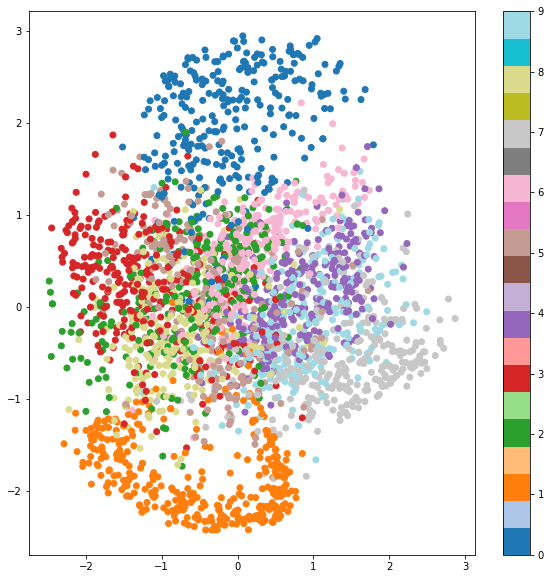

In [25]:
plt.figure(figsize=(10, 10))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

VAE的Decoder視覺化呈現

In [26]:
VAE_Decoder = Model(z_input, dec_1(dec_2(dec_3(z_input))))
VAE_Decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_11 (Dense)             (None, 150)               450       
_________________________________________________________________
dense_12 (Dense)             (None, 300)               45300     
_________________________________________________________________
dense_13 (Dense)             (None, 784)               235984    
Total params: 281,734
Trainable params: 281,734
Non-trainable params: 0
_________________________________________________________________


In [0]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [0]:
n = 15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

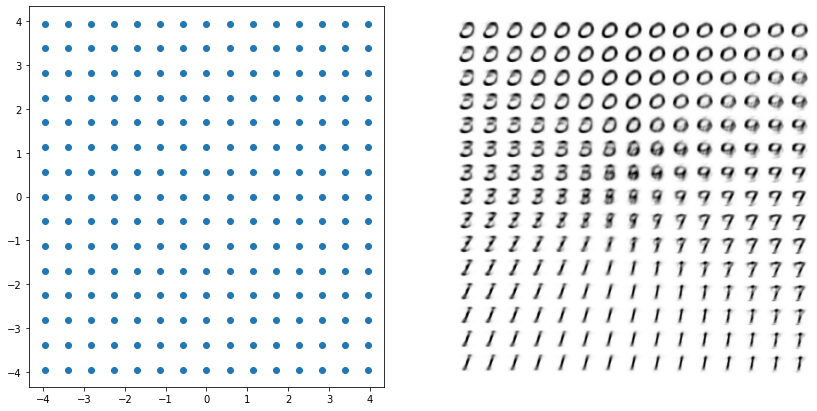

In [31]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()


動態比較

In [0]:
idx1, idx2 = np.random.randint(x_train.shape[0], size=2)

In [0]:
def inBetween(t):
    data_0 = x_train[idx1].reshape(28, 28)
    data_1 = x_train[idx2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

In [34]:
interact(inBetween, t=FloatSlider(value=0, min=0, max=1.0, step=0.02,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween>